In [65]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.metrics
import cv2
import json, pickle
import os, os.path
import importlib

import utils.sampletools as smpl
import utils.traintools as trnt

importlib.reload(smpl)
importlib.reload(trnt)

<module 'utils.traintools' from 'd:\\Programming\\NClassifier\\dev_tests\\tf01_cnn_detect\\utils\\traintools.py'>

In [67]:
def target_min_pct(sample, region, img_size, sample_area, region_area, overlap_area):
    if region is None:
        return 0.0
    return min(overlap_area/sample_area, overlap_area/region_area)

In [68]:
%%time
src_path = '../../dev_datasets/pass_sample/'
src_file = 'pass_general.json'

with open(os.path.join(src_path, src_file), 'r') as f:
    src_sample = json.load(f)

desc_name = src_file.split('.')[0]
for v in src_sample.values():
    sample, size_chain, fname = trnt.generate_sample_with_target_from_obs(v, path=src_path,
                                    max_size=1024, min_size=32, size_step=0.7071,
                                    sample_size=16, sample_stride=2,
                                    target=target_min_pct)
    img_name = os.path.split(fname)[1].split('.')[0]
    sname = os.path.join(src_path,  '{0}_{1}.pickle'.format(img_name, desc_name))
    with open(sname, 'wb') as f:
        pickle.dump((sample, size_chain, fname), f)
    print('Processed {}'.format(sname))

Processed ../../dev_datasets/pass_sample/01_pass_general.pickle
Processed ../../dev_datasets/pass_sample/02_pass_general.pickle
Processed ../../dev_datasets/pass_sample/03_pass_general.pickle
Processed ../../dev_datasets/pass_sample/04_pass_general.pickle
Processed ../../dev_datasets/pass_sample/05_pass_general.pickle
Processed ../../dev_datasets/pass_sample/06_pass_general.pickle
Processed ../../dev_datasets/pass_sample/08_pass_general.pickle
Processed ../../dev_datasets/pass_sample/08b_pass_general.pickle
Processed ../../dev_datasets/pass_sample/test_vs_pass_general.pickle
Wall time: 3min 3s


In [2]:
def score_file(path, fname, batch_size, calc_fun):
    res = []
    for (x, y) in generate_batches_from_file(path, fname, batch_size, shuffle=False):
        res.append(calc_fun(x))
    return np.hstack(res)

In [32]:
def generate_cnn(cnn_input, operations_list):
    tf_z = cnn_input
    for (mode, param) in operations_list:
        if mode == 'conv':
            tf_z = tf.layers.conv2d(tf_z, param['filters'], param['kernel'],
                                   **{k:v for (k,v) in param.items() if k not in ('filters', 'kernel')})
        elif mode == 'pool':
            tf_z = tf.layers.max_pooling2d(tf_z, param['pool_size'], param['strides'])
    return tf_z

def generate_fc(fc_input, descr_list):
    tf_z = fc_input
    for (sz, activation) in descr_list:
        tf_z = tf.layers.dense(tf_z, sz, activation=activation)
    return tf_z

def generate_cnn_fc(tf_in, cnn_list, dense_list):
    tf_x = generate_cnn(tf_in, cnn_list)
    tf_y = tf.reshape(tf_x, shape=(-1, int(np.prod(tf_res.shape[1:]))))
    return generate_fc(tf_y, dense_list)

In [35]:
def generate_graph(input_shape, cnn_list, dense_list):
    tf_input = tf.placeholder(shape=(None,*input_shape),dtype=tf.float32)
    tf_labels = tf.placeholder(shape=(None, 1),dtype=tf.float32)

    tf_y = tf.concat([tf_labels, 1-tf_labels], axis=1)
    tf_z = generate_cnn_fc(tf_input, cnn_list, dense_list)
    tf_p = tf.nn.softmax(tf_z)

    tf_loss = tf.nn.softmax_cross_entropy_with_logits(labels=tf_y, logits=tf_z)
    tf_train = tf.train.AdamOptimizer(1e-3).minimize(tf_loss)
    return {'x':tf_input, 'y':tf_labels, 'p':tf_p, 'train':tf_train, 'loss':tf_loss}

In [69]:
tf.reset_default_graph()

graph = generate_graph((16,16,3),[
            ('conv', {'filters':5, 'kernel':(3,3), 'activation':tf.nn.elu, 'strides':(1,1)}),
            ('pool', {'pool_size':(2,2), 'strides':(2,2)}),
            ('conv', {'filters':20, 'kernel':(3,3), 'activation':tf.nn.elu, 'strides':(1,1)}),
            ('pool', {'pool_size':(2,2), 'strides':(2,2)})
        ], [(20, tf.nn.elu), (2, None)])

In [72]:
num_epochs = 20
path = '../../dev_datasets/pass_sample/'
train_names = ['01_pass_general.pickle', 'test_vs_pass_general.pickle']
batch_size = 1024

result_p = dict()
tf_saver = tf.train.Saver(max_to_keep=2)

with tf.Session() as tfs:
    tfs.run(tf.global_variables_initializer())    
    for i in range(num_epochs):
        res_p = []
        res_y = []
        for fname in train_names:
            for (x, y) in generate_batches_from_file(path, fname, batch_size):
                tx = x / 255.0 - 0.5
                graph['train'].run(feed_dict={graph['x']: tx, graph['y']: y.reshape(-1, 1)})
                tp = graph['p'].eval(feed_dict={graph['x']: tx})[:,0]
                res_p.append(tp)
                res_y.append(y)
        full_p = np.hstack(res_p)
        full_y = np.hstack(res_y)
        tf_saver.save(tfs, 'models/pass_general_v2_{0:02d}'.format(i))
        print('step {0}, gini={1:.3f}'.format(i, sklearn.metrics.roc_auc_score(full_y>0.5, full_p)*2-1))   

step 0, gini=0.522
step 1, gini=0.835
step 2, gini=0.938
step 3, gini=0.967


KeyboardInterrupt: 

In [39]:
def combine_prediction(path, fname, probs):
    with open(os.path.join(path,fname), 'rb') as f:
        sample, size_chain, img_fname = pickle.load(f)
    targets = smpl.extract_targets_from_samples(sample)
    gini = 0
    if any(targets>0.5):
        gini = sklearn.metrics.roc_auc_score((targets>0.5)*1, probs) * 2 - 1
    return (generate_all_prediction_maps_2d(sample, probs), gini)

INFO:tensorflow:Restoring parameters from models/pass_general_03
Restored
Result for 01_pass_general.pickle is 0.938 gini
0.337419125168


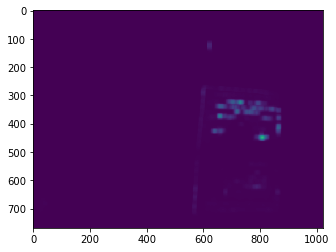

0.419468068168


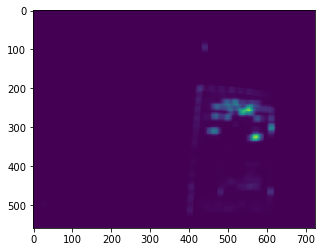

0.454096871013


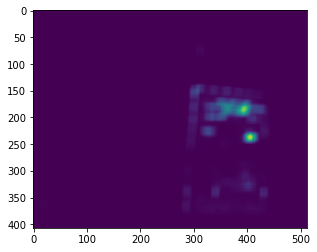

0.261422873125


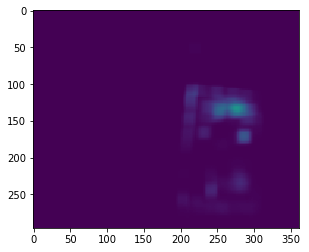

0.323401418224


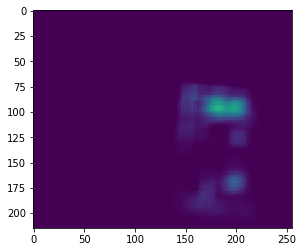

0.443770378013


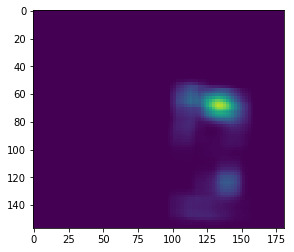

0.242428519319


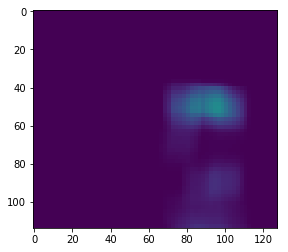

0.225578870422


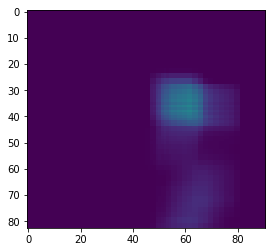

0.0990380186167


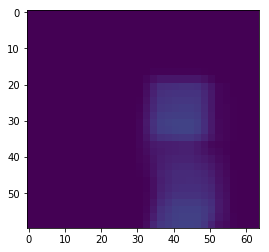

0.10213499836


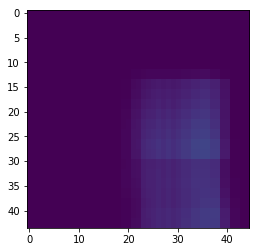

0.228244717543


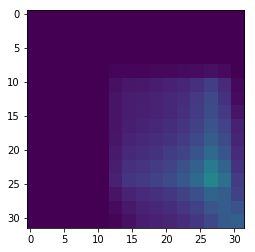

Result for 02_pass_general.pickle is 0.997 gini
0.0378844245279


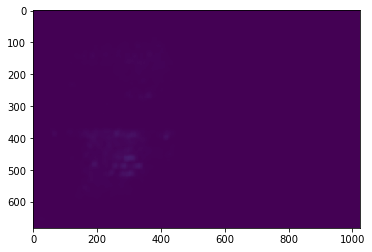

0.0799982566677


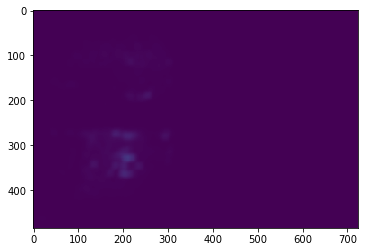

0.0746261642489


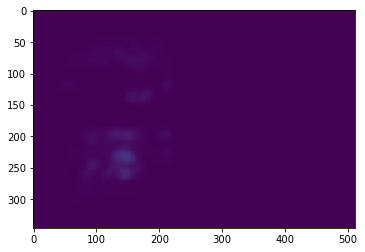

0.1056614361


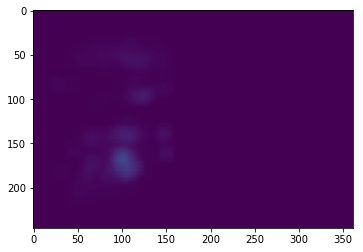

0.187323537306


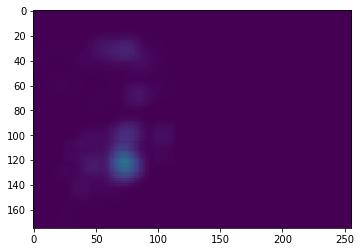

0.297172748542


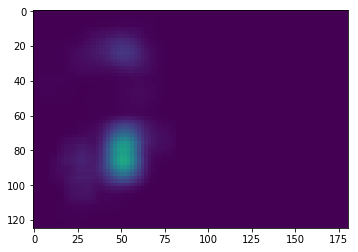

0.245197653596


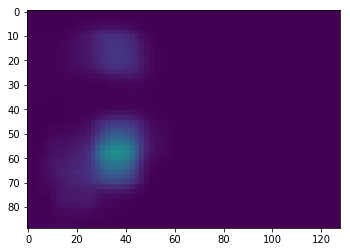

0.258414286654


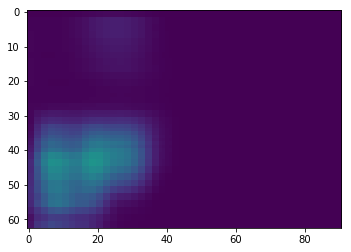

0.511337322493


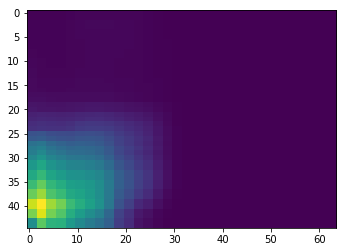

0.803241550922


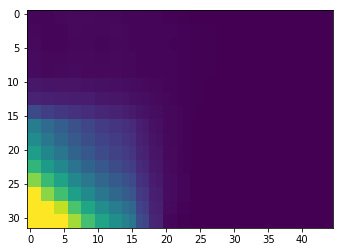

Result for 03_pass_general.pickle is 0.942 gini
0.727210700512


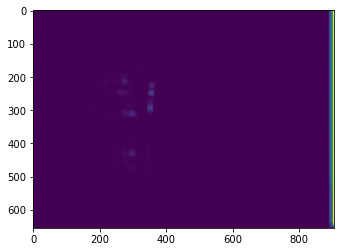

0.0258727629334


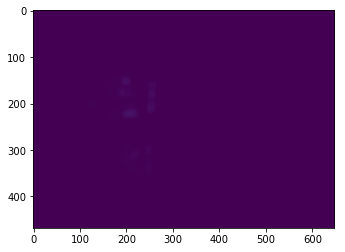

0.0311264741358


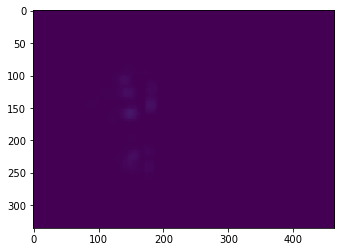

0.0167896234216


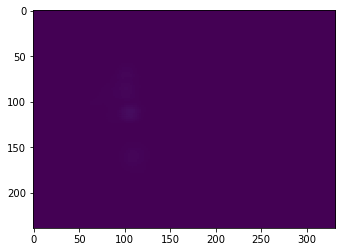

0.00848267817491


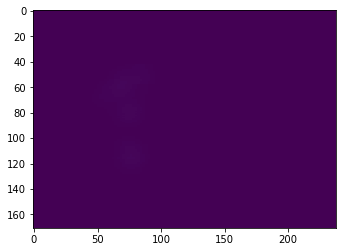

0.015204535739


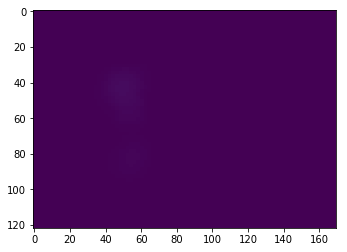

0.00994410195653


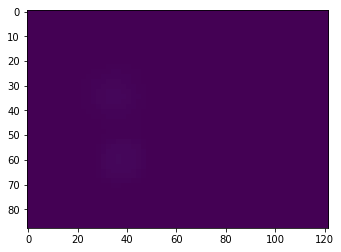

0.00623149131502


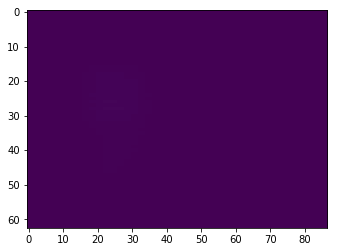

0.0175202070975


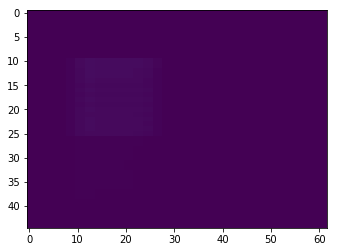

0.00489099832885


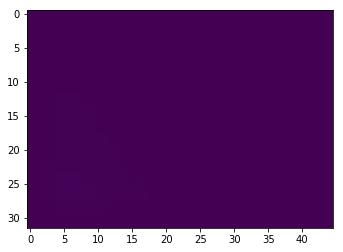

Result for 04_pass_general.pickle is 0.928 gini
0.887712438358


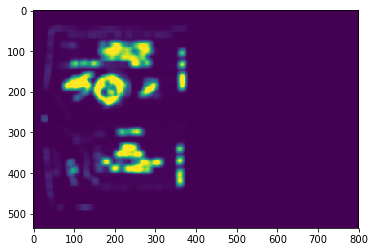

0.827854772564


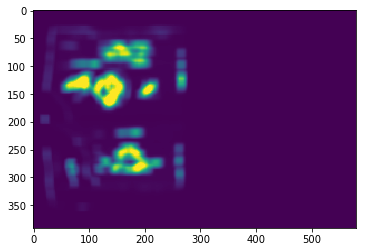

0.888913371367


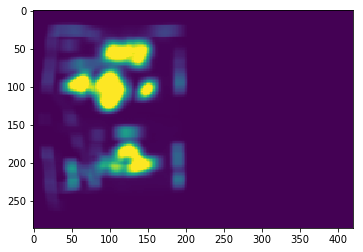

0.961998096667


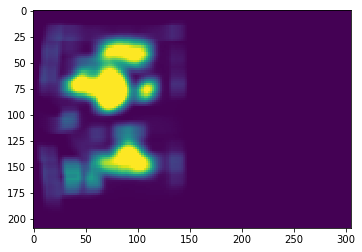

0.918426813558


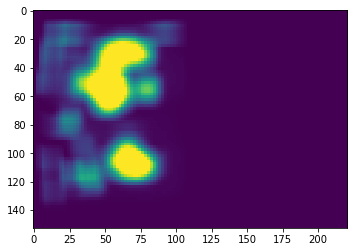

0.851890760707


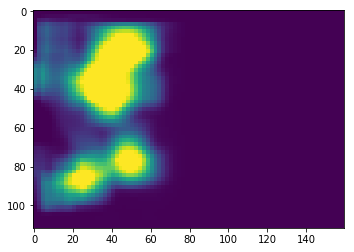

0.772797276732


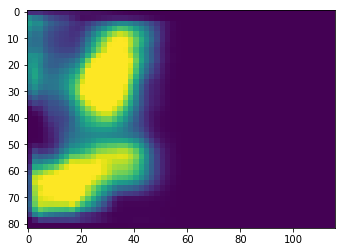

0.773033425212


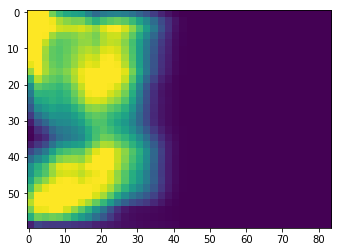

0.995538949966


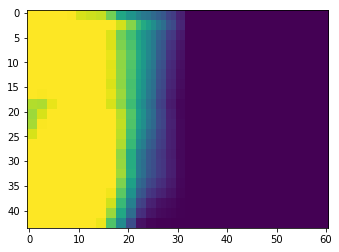

0.989805579185


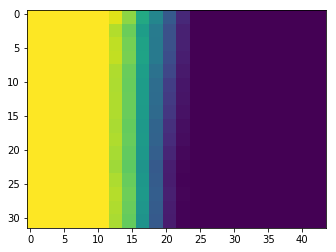

Result for 05_pass_general.pickle is 0.904 gini
0.752386756227


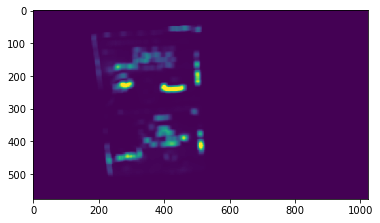

0.59936261145


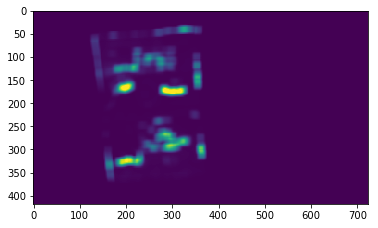

0.348559768521


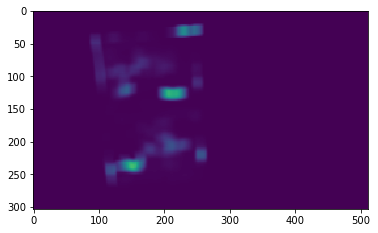

0.331796489907


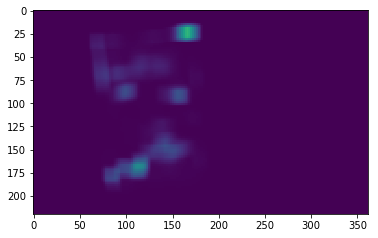

0.35760363788


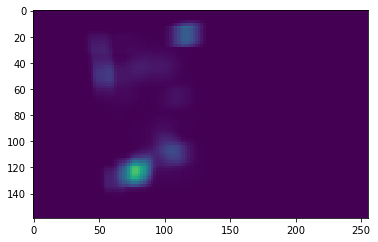

0.381642764041


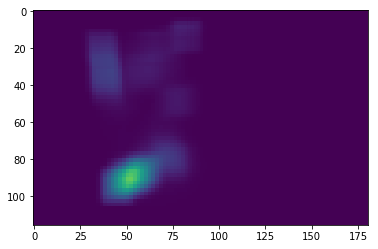

0.267936863627


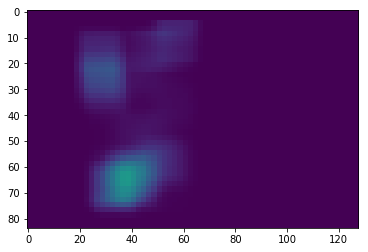

0.331411942927


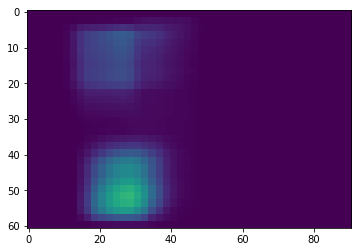

0.418822991371


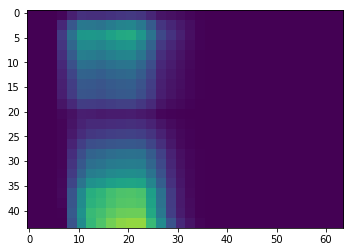

0.430001545697


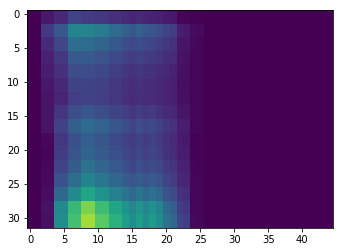

Result for 06_pass_general.pickle is 0.926 gini
0.497923352523


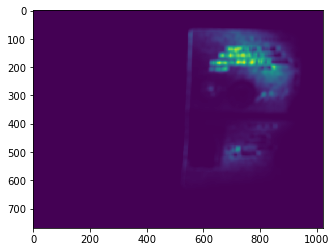

0.671527432743


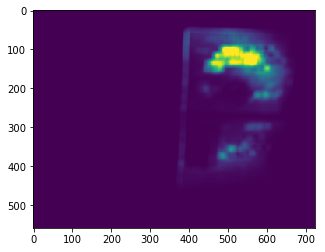

0.824508948252


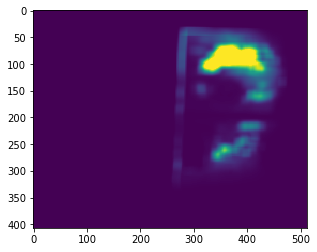

0.88946413435


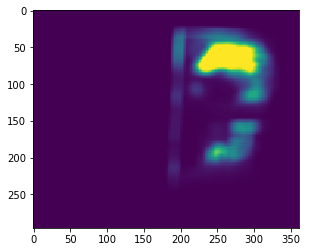

0.932362057269


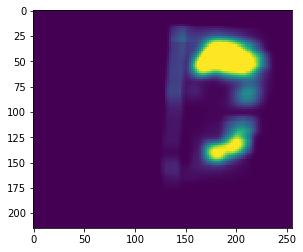

0.945554886945


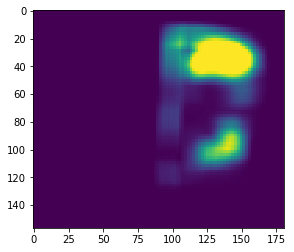

0.837503278628


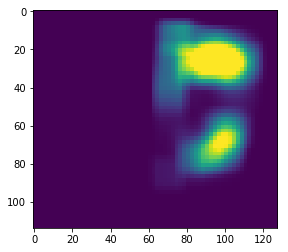

0.757100640563


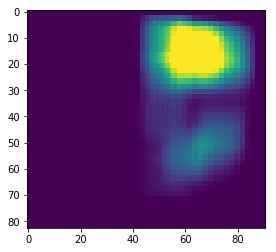

0.590020280459


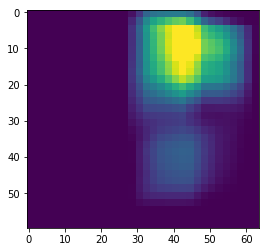

0.386470358208


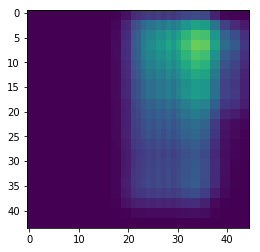

0.921724751592


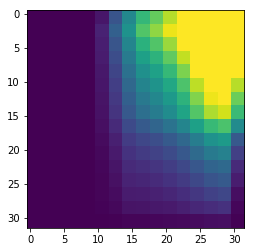

Result for test_vs_pass_general.pickle is 0.856 gini
0.000509097616558


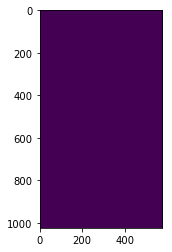

0.000935084287789


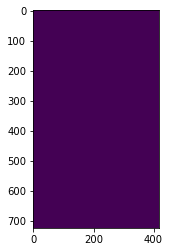

0.00165390266972


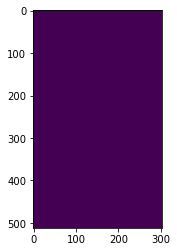

0.0014093485579


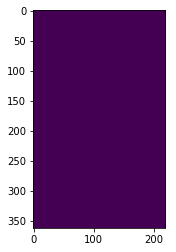

0.00186547020451


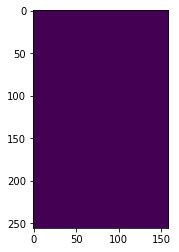

0.0108743529067


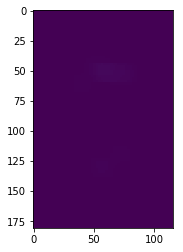

0.00424954157279


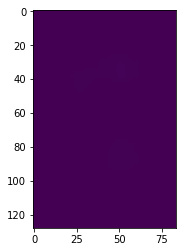

0.00611451656323


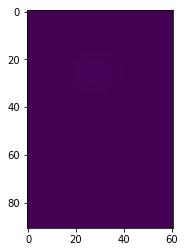

0.00352775154513


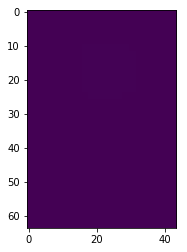

0.00102682584825


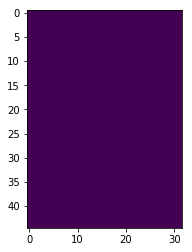

In [74]:
calc_names = ['01_pass_general.pickle', '02_pass_general.pickle',
              '03_pass_general.pickle', '04_pass_general.pickle',
              '05_pass_general.pickle', '06_pass_general.pickle',
              'test_vs_pass_general.pickle']
calc_batch_size = 16384
tf_saver = tf.train.Saver(max_to_keep=2)

with tf.Session() as tfs:
    tf_saver.restore(tfs, 'models/pass_general_03')
    print('Restored')
    for fname in calc_names:
        result_p = score_file(path, fname, calc_batch_size,
                              lambda x: graph['p'].eval(feed_dict={graph['x']: x / 255.0 - 0.5})[:,0])
        pmaps, gini = combine_prediction(path, fname, result_p)
        print('Result for {0} is {1:.3f} gini'.format(fname, gini))
        for pmap in pmaps:
            print(np.max(pmap))
            plt.imshow(pmap.transpose(), vmin=0, vmax=0.5)
            plt.show()